# Task C - Voronoi
This file aims to find divide the city of leeds into 10 different parts (cells), using the Voronoi algorithm. Then finding marathon distances within each cell, such that every person in Leeds can join a marathon close to their home. To achieve this notebook is divided into two main parts Finding seed points for Voronoi cells and Finding marathon distances with start=end.

**Finding seed points for Voronoi cells**
K-means is utilised to find 10 clusters based on spatial proximity, to try and divide the areas in Leeds equally. The closest node for each of the cluster centers are then used as the seeing points. After this, the voronoi diagram is visualised. 

**Finding marathon distances with start=end**
To find a path with a length equal to a marathon distance (42km) and the starting node equal has to be equal the end node, multiprocessing and the networkx.simple_cycle was utilised. When the program has started one worker for each cell is on the lookout for a marathon path. When a worker finds a marathon distance the worker is killed and if three or more marathon distances are found all workers are killed. After the marathon paths has been found a map displays all the voronoi cells as before with a red line for all marathon paths.  

Importing all needed imports and installing new imports.

In [1]:
!pip install multiprocess

In [2]:
import networkx as nx
import osmnx as ox
from taskC.voronoi_tutorial_helpers import nodes_nearest_seed, get_seed_color, map_node_color_from_seed, map_edge_color_from_node
from taskC.distance_metrices import FindMarathonDistance
import geopandas as gpd
from sklearn.cluster import KMeans
import matplotlib.pylab as plt

Loading the network and initialise global constant variables 

In [3]:
N_SEEDS = 10
query_place_graph = ox.graph_from_place('Leeds, United Kingdom', network_type='drive')

## Finding seed points for Voronoi cells
Here sklearn library KMeans is used to extract evenly distributed nodes together with the nearest_node method from the osmnx to find the closest node from the (x,y) coordinates coming from k-means.

In [4]:
def get_seeds_with_kmeans(graph: nx.MultiDiGraph, num_seeds: int):
    coords = [(node, data['x'], data['y']) for node, data in graph.nodes(data=True)]
    gdf_nodes = gpd.GeoDataFrame(coords, columns=['node_id', 'x', 'y'])
    kmeans = KMeans(n_clusters=num_seeds, init='k-means++')
    kmeans.fit(gdf_nodes[['x', 'y']])
    
    # These seeds aren't normally aligned with our map
    unaligned_seeds = [(x, y) for x, y in kmeans.cluster_centers_]
    # So we get the closest point
    return align_seeds(graph, unaligned_seeds)


def align_seeds(graph: nx.MultiDiGraph, unaligned_seeds: list[tuple]) -> list:
    nearest_node_ids = []
    for seed in unaligned_seeds:
        lat, lon = seed
        nearest_node_ids.append(ox.nearest_nodes(graph, lat, lon, return_dist=False))
    return nearest_node_ids

In [5]:
all_nodes = list(query_place_graph.nodes)
seeds = get_seeds_with_kmeans(query_place_graph, N_SEEDS)
seeds

[1560077,
 380917764,
 2044477309,
 317598187,
 1955838372,
 414203373,
 6481110432,
 1543142533,
 1690928998,
 305698610]

### Visualising the Voronoi diagram
The visualisation and the cell generations are from the week_6_sol.ipynb. Nodes in red are seed nodes while nodes in white are all other nodes.

In [6]:
cells = nx.voronoi_cells(query_place_graph, seeds, weight='length')

In [7]:
black_color = (0.0, 0.0, 0.0, 1.0)
node_seed_dict = nodes_nearest_seed(query_place_graph, seeds, cells)
seed_colors = get_seed_color(seeds, black_color)
node_color_dict = map_node_color_from_seed(query_place_graph, node_seed_dict, seed_colors)
edge_colors = map_edge_color_from_node(query_place_graph, node_seed_dict, node_color_dict, black_color)

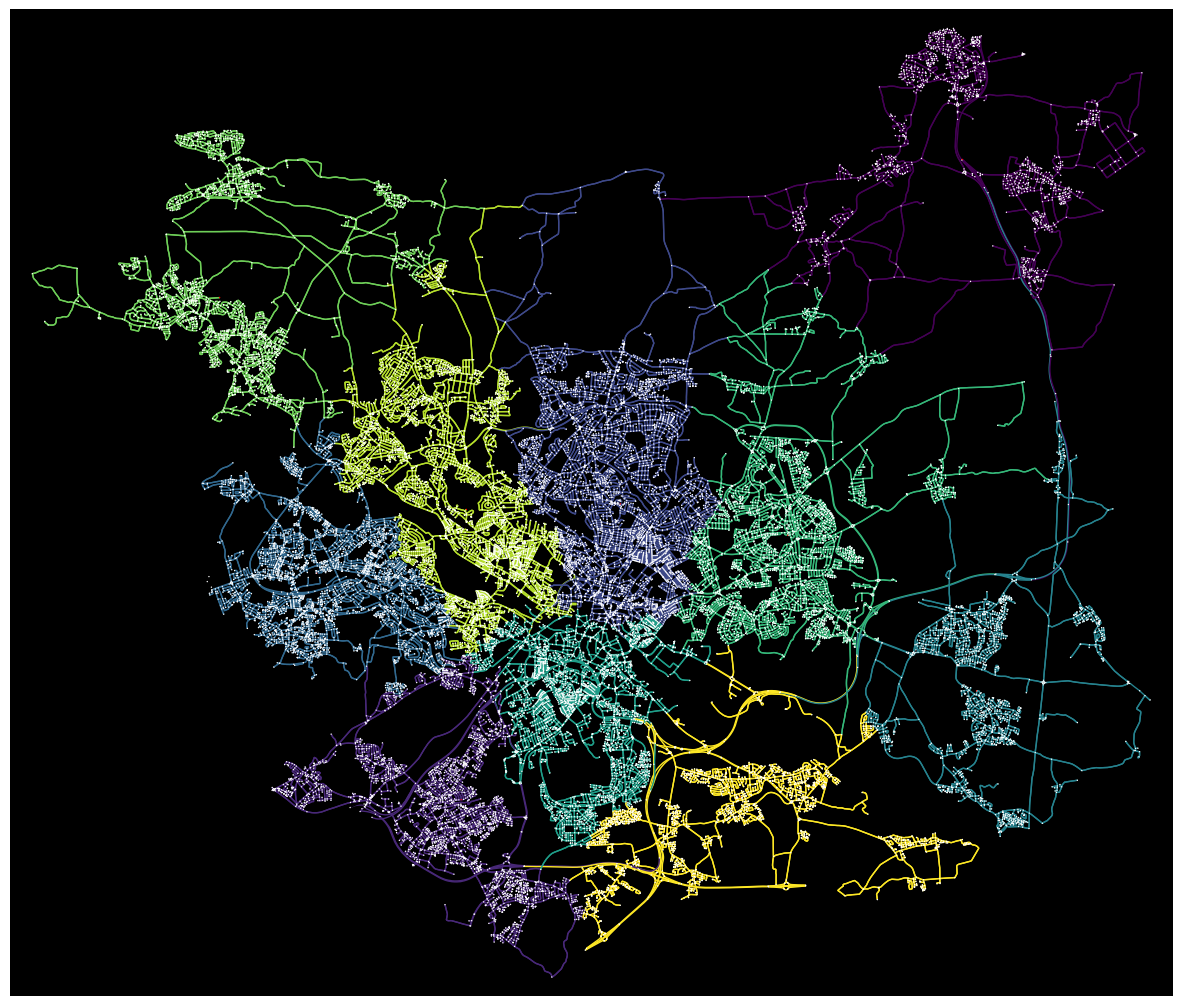

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [8]:
node_colors = ['r' if node in seeds else 'w' for node in all_nodes]
ox.plot.plot_graph(query_place_graph, 
                   edge_color=edge_colors, 
                   node_color=node_colors, 
                   bgcolor ='k', 
                   save=True, 
                   filepath='map.png',
                   dpi=500,
                   node_size=1, 
                   figsize=(15, 15))

## Finding marathon distances with start=end
Here a custom class is made to do the job, it can be find inside TaskC/distance_metric.py. The class goes over all simple maths and checks for marathon distances. In addition to speed up the process it uses multiprocessing

In [9]:
all_nodes = list(query_place_graph.nodes)
seeds = get_seeds_with_kmeans(query_place_graph, N_SEEDS)
cells = nx.voronoi_cells(query_place_graph, seeds, weight='length')

# Start 10 jobs here to look for marathon paths, when running you should see some statuses
marathon = FindMarathonDistance(query_place_graph, cells, seeds)

marathon.find_marathon_paths()
paths = marathon.get_marathon_paths()

looking over subgraph nodes 2940
finding cycles...
searching for marathon lengths...
looking over subgraph nodes 3771
finding cycles...
searching for marathon lengths...
looking over subgraph nodes 2290
finding cycles...
searching for marathon lengths...
looking over subgraph nodes 4868
finding cycles...
searching for marathon lengths...
looking over subgraph nodes 1470
finding cycles...
searching for marathon lengths...
looking over subgraph nodes 1758
finding cycles...
searching for marathon lengths...
looking over subgraph nodes 3023
finding cycles...
searching for marathon lengths...
looking over subgraph nodes 2955
finding cycles...
searching for marathon lengths...
looking over subgraph nodes 4922
finding cycles...
searching for marathon lengths...
looking over subgraph nodes 3263
finding cycles...
searching for marathon lengths...
there is hope!
MARATHON!!
Found a marathon path
[448708611, 448708540, 448708539, 448708536, 448708522, 448708524, 455592830, 448708519, 455592824, 45

### Visualisation the marathon paths

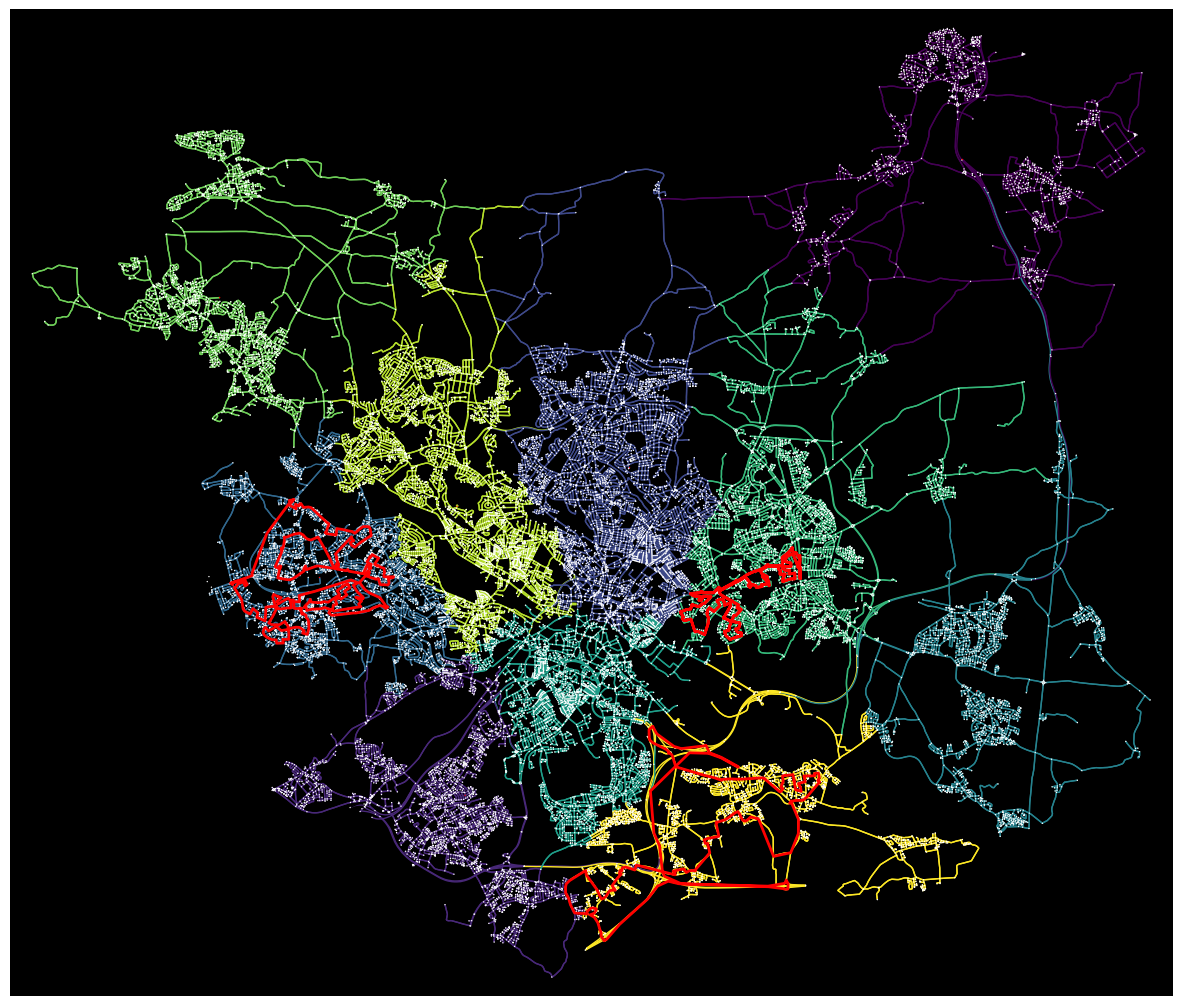

In [10]:
node_colors = ['r' if node in seeds else 'w' for node in all_nodes]

fig, ax = ox.plot.plot_graph(query_place_graph, 
                             edge_color=edge_colors, 
                             node_color=node_colors, 
                             bgcolor='k',
                             show=False, 
                             node_size=1, 
                             figsize=(15, 15),
                             dpi=800,)

for path in paths:
    x = [query_place_graph.nodes[node]['x'] for node in path]
    y = [query_place_graph.nodes[node]['y'] for node in path]
    ax.plot(x, 
            y, 
            color='red', 
            linewidth=2,)

plt.savefig('map_path.png', dpi=800)